<a href="https://colab.research.google.com/github/Anna-Misquitta/Sentiment_Based_Analysis/blob/main/Sentiment_Based_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
# Importing all the required libraries

import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import string
import pickle
import nltk
import time
import re

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import wordnet
from wordcloud import WordCloud
from sklearn import metrics
from numpy import *

# Downloading all the required modules
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Customising max no. of columns and its width respectively
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 500)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [183]:
# Importing data into our dataframe

data = pd.read_csv("/content/drive/MyDrive/capstone_data/sample30.csv")
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [184]:
# Check the attributes, null values of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [185]:
# Check missing values
data.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [186]:
# print the row that has missing value in user_sentiment column
data[data.user_sentiment.isnull()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


In [187]:
# We can observe that user's sentiment is positive based on their comment. Hence we will replace the NaN value with Positive value.
data.loc[28354,'user_sentiment'] = 'Positive'

In [188]:
# print the row and check if missing value in user_sentiment column has been replaced with our data 
data[data.index == 28354]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,Positive


In [189]:
# Replacing positive values with 1 and negatives with 0
data['user_sentiment'] = data['user_sentiment'].map({ 'Positive' : 1, 'Negative' :0})
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,NaN,NaN,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,0


In [190]:
# Check if there is any imbalance in data in percentage
round((data["user_sentiment"].value_counts(normalize=True)*100),2)

1    88.78
0    11.22
Name: user_sentiment, dtype: float64

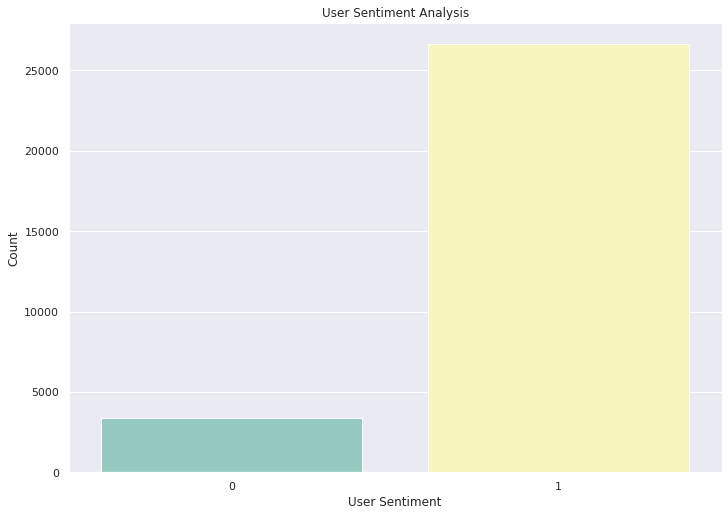

In [191]:
# Visualizing the above data
plt.title('User Sentiment Analysis')
sns.countplot(x='user_sentiment', data= data, palette="Set3")
plt.ylabel('Count')
plt.xlabel('User Sentiment')
plt.show()

In [192]:
# We can observe that there is high class imbalance as 88.78% of our data has positive reviews and only 11.22% has negative reviews.
# Hence we will have to take various steps to handle this problem.

In [193]:
# Check the various ratings given by different users to different products
data["reviews_rating"].describe()

count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

In [194]:
# Check different values present in the rating column
data["reviews_rating"].value_counts(normalize=True)*100

5    69.436667
4    20.066667
1     4.613333
3     4.483333
2     1.400000
Name: reviews_rating, dtype: float64

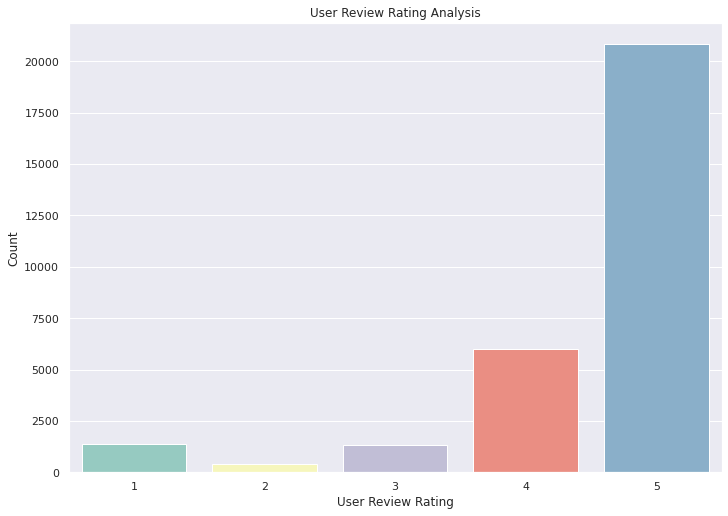

In [195]:
# Visualizing the above data
plt.title('User Review Rating Analysis')
sns.countplot(x='reviews_rating', data= data, palette="Set3")
plt.ylabel('Count')
plt.xlabel('User Review Rating')
plt.show()

In [196]:
# Checking positive reviews values
data[data["user_sentiment"] == 1]["reviews_rating"].describe()

count    26633.000000
mean         4.560395
std          0.865182
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

In [197]:
# Checking negative reviews values
data[data["user_sentiment"] == 0]["reviews_rating"].describe()

count    3367.000000
mean        3.871993
std         1.537589
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: reviews_rating, dtype: float64

In [198]:
# Check reviews_title,reviews_text and reviews_rating where user sentiment is positive and rating is less than 3
data[(data["user_sentiment"] == 1 ) & (data["reviews_rating"] < 3)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,1
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,1
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,1
54,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",1
56,Please bring back the old formula,"I am so disappointed! I have used this product for years because of it's soft smell and great results. The new formula feels greasy, smells awful and I don't feel like my skin looks as toned and wrinkle free anymore. This was a five star product for so many years...why change it Please bring back the old formula.",1
...,...,...,...
28869,Last Step!,"This was the last step out of the three step process. I will say that this was my least favorite step. The product is designed to take the oil away from your roots and bring moisture to your ends. However, I feel that this brought oil to all of my hair which is why I was left oily later in the day! The smell is great, but I would probably try and use a different conditioner. I received this product free for testing purposes, but all opinions are my own. This review was collected as part of a...",2
28870,"Unfortunately, Not For My Hair","I have been a big LOral fan, using their products for more than a decade now. For the past three weeks I have been testing the LOral Paris Hair Expert Extraordinary Clay range - the mask, shampoo and conditioner. I have curly hair with a normal scalp. I have been testing all three products during my regular hair care routine, but also just the shampoo and conditioner without the mask. After applying the mask which felt weird on my scalp (hard to apply, tangled up my hair pretty badly), I use...",2
28871,I Really Wanted To Love This But...,"Despite using this with the line's hair mask and shampoo, I didn't find much difference in oil control the next day and still felt the need to use dry shampoo. It smells nice and made my hair feel soft, but it just didn't live up to all of its promises, in my opinion. Such a shame too because I love the concept and really wanted this to work for me! I received this product free for testing purposes, but all opinions are my own. This review was collected as part of a promotion.",2
28872,Just Not For Me,"I tried out this whole set.i wanted it to work but the scent wasn't favorable and my hair felt really dry, hard and stiff after and I've always been so proud of my soft hair. I tried using this for a week or so but had to stop in fear that I was causing permanent damage to my hair. This review was collected as part of a promotion.",2


In [199]:
# Check reviews_title,reviews_text and reviews_rating where user sentiment is negative and rating is greater than 3
data[(data["user_sentiment"] == 0) & (data["reviews_rating"] > 3)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,4
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,4
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,4
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",4
117,Not greasy,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",4
...,...,...,...
29818,Great Product,"I received a complimentary sample of this product and it worked so well for my hair! I have very thick hair so my roots always get oily and my ends are dry, this left my hair the cleanest it's felt in a long time. Will def recommend this to my family and friends! This review was collected as part of a promotion.",5
29855,Great,This has prolonged the color in my hair! Not only is my hair healthier but I think I'll have to visit my stylist less! This review was collected as part of a promotion.,5
29858,Makes my hair soft and shiny without excess oil!,"This conditioner makes my hair very soft without weighing it down! I was afraid it'd make my roots more oily and weight them down, but it doesn't one bit! My hair is colored, and it hasn't faded out the color either! I'd highly recommend giving this a try! This review was collected as part of a promotion.",5
29862,Great Conditioner,This conditioner has become a staple in my hair regimen This review was collected as part of a promotion.,5


In [200]:
# We can observe that where user sentiment is positive and the rating is less than 3 user review is actually negative but recorded as positive.
# Also where user sentiment is negative and the rating is greater than 3 user review is actually positive but recorded as negative.
# Hence we will update the target column values accordingly.

In [201]:
#  Updating the user_sentiment to 0 which was 1 when the reviews_rating is less than 3
data.loc[(data["user_sentiment"] == 1 ) & (data["reviews_rating"] < 3),'user_sentiment'] = 0

#  Updating the user_sentiment to 1 which was 0 when the reviews_rating is greater than 3
data.loc[(data["user_sentiment"] == 0) & (data["reviews_rating"] > 3),'user_sentiment'] = 1

In [202]:
# Checking the imbalance in data (Percentage format)
round((data["user_sentiment"].value_counts(normalize=True)*100),2)

1    93.25
0     6.75
Name: user_sentiment, dtype: float64

In [203]:
# Checking the imbalance in data (Number of rows)
data["user_sentiment"].value_counts()

1    27976
0     2024
Name: user_sentiment, dtype: int64

In [204]:
# Checking if user rating and user sentiment go hand in hand
pd.crosstab(data["reviews_rating"], data["user_sentiment"], margins=True)

user_sentiment,0,1,All
reviews_rating,,,
1,1384,0,1384
2,420,0,420
3,220,1125,1345
4,0,6020,6020
5,0,20831,20831
All,2024,27976,30000


In [205]:
# Filter the top 20 brands among the positive sentiments
data[data['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:20]

brand
Clorox                  10529
Warner Home Video        3175
Disney                   1188
L'oreal Paris            1110
Burt's Bees               838
FOX                       834
Sony Pictures             831
Summit Entertainment      800
Universal Home Video      648
Olay                      622
Warner Bros.              438
Lundberg                  401
Hoover                    322
Avery                     314
Pendaflex                 292
Windex                    283
Tostitos                  267
Vaseline                  246
Storkcraft                241
Warner Music Group        200
Name: brand, dtype: int64

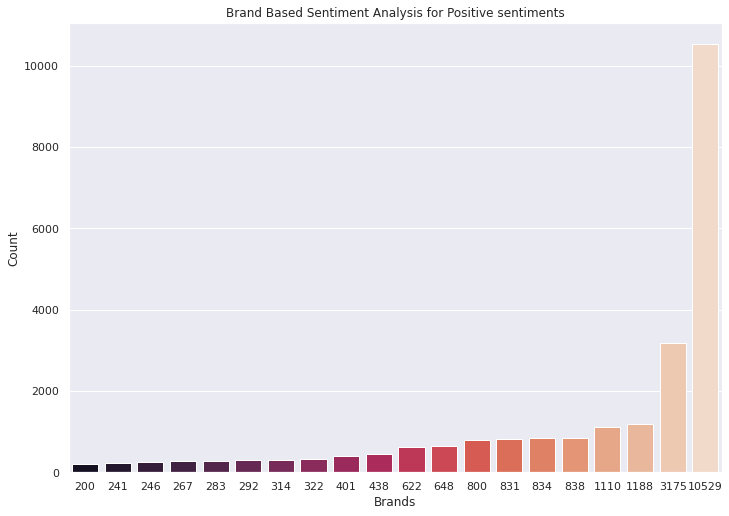

In [206]:
# Visualize the top 20 brands among the positive sentiments
plt.title('Brand Based Sentiment Analysis for Positive sentiments')
sns.set(rc={'figure.figsize':(11.7, 8.27)})
brand_data_positive = data[data['user_sentiment'] == 1].groupby('brand')['brand'].count().sort_values(ascending=False)[:20]
sns.barplot(x=brand_data_positive.index, y = brand_data_positive.values ,data= brand_data_positive, palette="rocket")
plt.ylabel('Count')
plt.xlabel('Brands')
plt.show()

In [207]:
# Filter the top 20 brands among the negative sentiments
data[data['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:20]

brand
Nexxus                        634
Clear Scalp & Hair Therapy    192
Warner Home Video             150
Aveeno                        118
L'oreal Paris                  76
Windex                         65
Clorox                         56
FOX                            53
Burt's Bees                    43
Hoover                         40
L'Oreal Paris                  36
Just For Men                   28
Storkcraft                     23
Hormel                         21
Warner Bros.                   20
Universal Home Video           20
Tostitos                       19
Pendaflex                      18
K-Y                            16
Olay                           15
Name: brand, dtype: int64

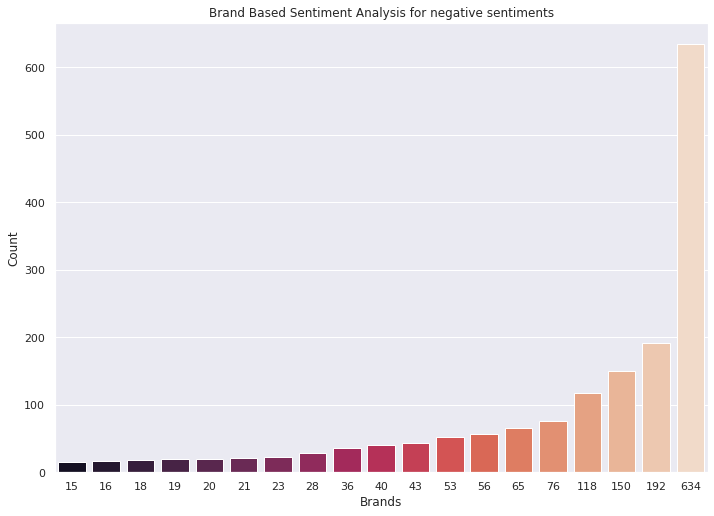

In [208]:
# Visualize the top 20 brands among the negative sentiments
plt.title('Brand Based Sentiment Analysis for negative sentiments')
sns.set(rc={'figure.figsize':(11.7, 8.27)})
brand_data_negative = data[data['user_sentiment'] == 0].groupby('brand')['brand'].count().sort_values(ascending=False)[:20]
sns.barplot(x=brand_data_negative.index, y = brand_data_negative.values ,data= brand_data_negative, palette="rocket")
plt.ylabel('Count')
plt.xlabel('Brands')
plt.show()

In [209]:
#group the dataframe by product id and view the positive review / negative reviews count
data_summary =  data.groupby('id', as_index=False)['user_sentiment'].count()
data_summary["positive_review_count"] =  data_summary.id.apply(lambda id: data[(data.id==id) & (data.user_sentiment==1)]['brand'].count())
data_summary["negative_review_count"] =  data_summary.id.apply(lambda id: data[(data.id==id) & (data.user_sentiment==0)]['brand'].count())
data_summary['sentiment_percent'] = np.round((data_summary['positive_review_count']/data_summary['user_sentiment'])*100,2)
data_summary.head(20)

,id,user_sentiment,positive_review_count,negative_review_count,sentiment_percent
0,AV13O1A8GV-KLJ3akUyj,1,1,0,100.00
1,AV14LG0R-jtxr-f38QfS,2,2,0,100.00
2,AV16khLE-jtxr-f38VFn,27,11,16,40.74
3,AV1YGDqsGV-KLJ3adc-O,348,283,65,81.32
4,AV1YIch7GV-KLJ3addeG,1,1,0,100.00
5,AV1YlENIglJLPUi8IHsX,17,14,3,82.35
6,AV1YmBrdGV-KLJ3adewb,18,18,0,100.00
7,AV1YmDL9vKc47QAVgr7_,89,78,11,87.64
8,AV1Ymf_rglJLPUi8II2v,34,34,0,100.00
9,AV1Yn94nvKc47QAVgtst,25,24,1,96.00


In [210]:
# Text Preprocessing for Modelling

In [211]:
# Checking reviews and user sentiment values
data[["reviews_text", "user_sentiment"]].sample(30)

,reviews_text,user_sentiment
7179,Great easy cleaning item..use it to wipe down the litter box and it helps keep it smelling fresh. This review was collected as part of a promotion.,1
13193,"love the wipes, they are quick and easy and great for the car, school and home. I also use them at my work office for wiping up my phone, computer and desk to risk germs. This review was collected as part of a promotion.",1
23375,Love the 3D effects and sound. Awesome on the big screen :),1
28484,Chair was easy to assemble and it surprisingly comfortable however ottoman came totally broken and its not easy getting a replacement from the factory,1
17485,I like the product because it yields a very natural looking result. I have used it at least half a dozen times and I have been very impressed with the outcome. I do highly recommend this product.,1
7901,I love to have these around to clean up quick messes. This review was collected as part of a promotion.,1
21554,So disappointed in the new formula. It gives my fine and body less hair no hold and leaves my hair filmy and flat. This product no longer works well when using a curling or flat iron. I want the old formula back. Why change a product that has worked great for years. So disappointed I bought two tubes of this as I didn't ever want to run out of the original product. I will be looking for something else. Please email me if you change the formula back to the original.,0
28157,"Cute movie, great addition to Cars, Cars 2, etc! 2 year old grandson loves anything to, do with cars, boats, planes, construction sites and trucks!",1
19605,"I love the ease of use and effectiveness of the Clorox wipes, they are easy to use on all surfaces and I know it leaves my house clean.",1
3072,THIS MOVIE JUST NEEDED TO NEVER STOP AND ADDED SO MUCH FROM THE ORIGINAL,1


In [212]:
# Inialisation of various methods
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [213]:
# Functions to perform various text pre processing steps
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
  word_pos_tags = nltk.pos_tag(word_tokenize(text))
  words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
  return " ".join(words)

def pre_process_text(text_data):
    # Convert string to lowercase
    text_data = text_data.lower()

    # Strip all the extra spaces in the beginning and at the end of the string
    text_data = text_data.strip()

    # Remove all extra spaces from between words
    text_data = re.sub("\[\s*\w*\s*\]", "", text_data)

    # Remove punctuations
    dictionary = "abc".maketrans('', '', string.punctuation)
    text_data = text_data.translate(dictionary)
    text_data = re.sub("\S*\d\S*", "", text_data)
    
    # Removal of stopwords
    words = [word for word in text_data.split() if word.isalpha() and word not in stop_words]
    text_data = " ".join(words)

    # Text lemmatization
    text_data = lemmatize_text(text_data)
    return text_data

In [ ]:
# Cleaning the data using various pre-processing steps 
clean_data = data[['id','name', 'reviews_text', 'user_sentiment']]
clean_data["reviews_cleaned_text"] = clean_data.reviews_text.apply(lambda text: pre_process_text(text))

In [ ]:
# Checking the cleaned data
clean_data.head()

In [ ]:
#Using a word cloud to find the words by frequency among all the articles after processing the text
wordcloud = WordCloud(stopwords=stop_words, max_words=200,  background_color="white", max_font_size=50).generate(str(clean_data.reviews_cleaned_text))
print(wordcloud)
plt.figure(figsize= (10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

In [ ]:
# Splitting the data and the target variable into X and y variables respectively
X = clean_data.reviews_cleaned_text
y = clean_data.user_sentiment

In [ ]:
# Feature Extraction

In [ ]:
# Counting the number of the unique values present in the target column
no_of_classes= len(pd.Series(y).value_counts())

In [ ]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
    print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

In [ ]:
# Making Bag of words model
bow = {}
for value in X:
    words = nltk.word_tokenize(value)
    for word in words:
        if word not in bow.keys():
            bow[word] = 1
        else:
            bow[word] += 1
# Sorting the bag of words model in descending order
sorted_bow = sorted(bow.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Checking the sorted bag of words model
sorted_bow

In [ ]:
# calculating tf-idf values
tfidf_model = TfidfVectorizer(stop_words='english', max_features=700, max_df=0.9, min_df=7, binary=True, ngram_range=(1,2))

# Storing the tf-idf result for X in X_train_tfidf
X_train_tfidf = tfidf_model.fit_transform(X)

In [ ]:
# splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

In [ ]:
# Handling class imbalance using SMOTE

In [ ]:
counter = Counter(y_train)
print('Before : ',counter)
smote = SMOTE()
# transform the dataset
X_train, y_train = smote.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After : ',counter)

In [ ]:
# Creating model builder class and various functions required for the same so as avoid code replication
class ModelBuilder:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def train_model(self):
        self.model.fit(self.X_train,self.y_train)
        return self.model.predict(self.X_test)
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*50)
        self.result = self.evaluate_scores(y_pred_class)
        print("*"*50)
        print("\n")
        self.classification_report(y_pred_class)
        print("*"*50)
        print("\n")
        self.confusion_matrix(y_pred_class)
        print("*"*50)
        print("\n")
        metrics.plot_roc_curve(self.model, self.X_test, self.y_test)
        return self.result
        
    def evaluate_scores(self, y_pred_class):
        result_arr = [] 
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.X_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)
        print(f"Accuracy = {accuracy*100:.1f}%")
        print(f"Precision = {precision*100:.1f}%")
        print(f"Recall = {recall*100:.1f}%")
        print(f"F1 Score = {f1score*100:.1f}%")
        print(f"Roc-Auc Score is = {roc_auc*100:.1f}%")
        result_arr.append(accuracy)
        result_arr.append(precision)
        result_arr.append(recall)
        result_arr.append(f1score)
        result_arr.append(roc_auc)
        return result_arr
        
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])
        
    def plot_confusion_matrix(self, plot_data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(plot_data/np.sum(plot_data), annot=True, cmap="PiYG")
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set(ylabel="Actual Values", xlabel="Predicted Values")
        plt.show()
        
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

In [ ]:
# Logistic Regression

In [ ]:
# Build the Logistic Regression model.
%time
logistic_regression_model = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
logistic_regression_model_builder = ModelBuilder(logistic_regression_model, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred_class  = logistic_regression_model_builder.train_model()
logistic_regression_metrics = logistic_regression_model_builder.evaluate_model(y_pred_class)

In [ ]:
# Multinomial Naive Bayes

In [ ]:
# training the NB model and making predictions
multinomial_naive_bayes = MultinomialNB(alpha=1.0)
multinomial_naive_bayes_modebuilder = ModelBuilder(multinomial_naive_bayes, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred_class  = multinomial_naive_bayes_modebuilder.train_model()
multinomial_naive_bayes_metrics = multinomial_naive_bayes_modebuilder.evaluate_model(y_pred_class)

In [ ]:
# Decision Tree

In [ ]:
# Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)
decision_tree_modelbuilder = ModelBuilder(decision_tree, X_train, X_test, y_train, y_test)
y_pred_class  = decision_tree_modelbuilder.train_model()
decision_tree_metrics_cv = decision_tree_modelbuilder.evaluate_model(y_pred_class)

In [ ]:
# Random Forrest

In [ ]:
# Random Forrest
random_forest = RandomForestClassifier(oob_score=True, random_state=52, criterion="gini")
params = {
    'max_depth': [2,4,6,8,10],
    'min_samples_leaf': [5,10,15,20,25,50],
    'n_estimators': [10, 17, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=random_forest,param_grid=params,cv = 4,n_jobs=-1, verbose=1, scoring="f1")
%time
grid_search.fit(X_train, y_train)
random_forest_best = grid_search.best_estimator_
random_forest_modebuilder = ModelBuilder(random_forest_best, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred_class  = random_forest_modebuilder.train_model()
random_forest_metrics = random_forest_modebuilder.evaluate_model(y_pred_class)

In [ ]:
# XGBoost Classifier

In [ ]:
# XGBoost Classifier
xg_boost = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_boost_modebuilder = ModelBuilder(xg_boost, X_train, X_test, y_train, y_test)
# Train and Predict the Test Labels
y_pred_class  = xg_boost_modebuilder.train_model()
xg_boost_metrics = xg_boost_modebuilder.evaluate_model(y_pred_class)

In [ ]:
# Creating a table which contains all the metrics
metrics_table = {
    'Metric': ['Accuracy','Precision','Recall','F1Score','Auc Score'],
    'Logistic Regression': logistic_regression_metrics,
    'Naive Bayes': multinomial_naive_bayes_metrics,
    'Decision Tree': decision_tree_metrics_cv,
    'Random Forrest': random_forest_metrics,
    'XG Boost': xg_boost_metrics}
data_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest','XG Boost'] )
data_metrics

In [ ]:
# creating a function to save the models
def save_object(obj, filename):
    filename = "pickle\\"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [ ]:
# Since XGBoost has performed well compared to all the other models. Hence we will use XGBoost model for our future predictions

In [ ]:
#  Saving the models
save_object(xg_boost, 'sentiment_classification_xg_boost_model')

# Using tf-idf vectorizer for understanding importance of various words in a given context
save_object(tfidf_model, 'tfidf_vectorizer')

# Saving the cleaned corpus of text
save_object(clean_data, 'cleaned_data')

In [ ]:
# Creating a seperate dataframe for recommendation system

data_recommendation = data[["id", "name", "reviews_rating", "reviews_username"]]
data_recommendation.isnull().sum()

In [ ]:
#splitting the data into train and test
train, test = train_test_split(data_recommendation, test_size=0.25, random_state=52)

In [ ]:
# Checking if the data has split perfectly
print("Train : ",train.shape,"Test",test.shape,sep="\n")

In [ ]:
def create_pivot(dataset,index,columns,values,fillna):
  pivot_format = pd.pivot_table(dataset,
    index=index,
    columns=columns,
    values=values
  )
  if fillna == -1 :
    return pivot_format
  else:
    return pivot_format.fillna(fillna)

def mark_all_rated_rows_as_one(index,dummy_dataset):
  return dummy_dataset[index].apply(lambda value: 0 if value>=1 else 1)

def final_rating(predicted_values,dummy_dataset):
    return np.multiply(predicted_values,dummy_dataset)

In [ ]:
# Creating a pivot table with user name as row index, product id as column index and review rating as cell values
data_pivot = create_pivot(train,"reviews_username","id","reviews_rating",0)
data_pivot.head(10)

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

# Checking the dummy train dataset
dummy_train.head()

In [ ]:
# Marking all the products not rated by users as 1 in the dummy traub dataset
dummy_train["reviews_rating"] = mark_all_rated_rows_as_one("reviews_rating",dummy_train)

In [ ]:
# Creating a pivot table with user name as row index, product id as column index and review rating as cell values for the dummy train dataset
dummy_train = create_pivot(dummy_train,"reviews_username","id","reviews_rating",1)
dummy_train.head(10)

In [ ]:
# Checking the number of unique users present in the dataset
data_pivot.index.nunique()

In [ ]:
#using cosine similarity to compute the distance.
correlation_dataset = cosine_similarity(data_pivot)
correlation_dataset[np.isnan(correlation_dataset)] = 0
print(correlation_dataset)
print(correlation_dataset.shape)

In [ ]:
#filtering out the user_correlation that are negatively correlated
correlation_dataset[correlation_dataset<0]=0
correlation_dataset

In [ ]:
# Predict the ratings using dot product of correlation matrix and existing ratings
predicted_ratings = np.dot(correlation_dataset, data_pivot)
predicted_ratings

In [ ]:
#since we are interested in products that are not rated by the userhence we multiply the predicted rating with dummy train so as to make the pre-rated values zero.
final_rating = final_rating(predicted_ratings,dummy_train)
final_rating.head()

In [ ]:
user_input = "00sab00" 
print(user_input)

In [ ]:
recommendations = final_rating.loc[user_input].sort_values(ascending=False)[0:10]
recommendations

In [ ]:
#display the top 10 product id, name and similarity score 
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

In [ ]:
# Find out the common users of test and train dataset.
common_users = test[test.reviews_username.isin(train.reviews_username)]
common_users.shape

In [ ]:
common_users.head()

In [ ]:
# convert into the user-product matrix.
common_user_based_matrix = pd.pivot_table(common_users,index="reviews_username", columns = "id", values = "reviews_rating")
common_user_based_matrix.head()

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_dataset = pd.DataFrame(correlation_dataset)
user_correlation_dataset.head()

In [ ]:
user_correlation_dataset["reviews_username"] = data_pivot.index
user_correlation_dataset.set_index("reviews_username",inplace=True)
user_correlation_dataset.head()

In [ ]:
list_name = common_users.reviews_username.tolist()
user_correlation_dataset.columns = data_pivot.index.tolist()
user_correlation_dataset_1 =  user_correlation_dataset[user_correlation_dataset.index.isin(list_name)]
user_correlation_dataset_1.shape

In [ ]:
user_correlation_dataset_2 = user_correlation_dataset_1.T[user_correlation_dataset_1.T.index.isin(list_name)]

In [ ]:
user_correlation_dataset_3 = user_correlation_dataset_2.T

In [ ]:
user_correlation_dataset_3[user_correlation_dataset_3<0]=0
common_user_predicted_ratings = np.dot(user_correlation_dataset_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

In [ ]:
dummy_test = common_users.copy()
dummy_test["reviews_rating"] = dummy_test["reviews_rating"].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index="reviews_username", columns = "id", values = "reviews_rating").fillna(0)
dummy_test.shape

In [ ]:
common_user_based_matrix.head()

In [ ]:
dummy_test.head()

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

In [ ]:
#calculate RMSE
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
common_ = pd.pivot_table(common_users,index="reviews_username", columns = "id", values = "reviews_rating")

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

In [ ]:
# Item Based Recommendation

In [ ]:
df_pivot = pd.pivot_table(train,
    index="id",
    columns="reviews_username",
    values="reviews_rating"
)

df_pivot.head()

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

In [ ]:
# Take the user ID as input
user_input = '00sab00'
print(user_input)

In [ ]:
# Recommending the Top 20 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

In [ ]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

In [ ]:
common =  test[test.id.isin(train.id)]
common.shape

In [ ]:
common.head(4)

In [ ]:
common_item_based_matrix = common.pivot_table(index="id", columns="reviews_username", values="reviews_rating")
print(common_item_based_matrix.shape)


In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

In [ ]:
item_correlation_df["id"] = df_subtracted.index
item_correlation_df.set_index("id",inplace=True)
item_correlation_df.head()

In [ ]:
list_name = common.id.tolist()

In [ ]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
df_subtracted

In [ ]:
item_correlation_df_3[item_correlation_df_3 < 0]=0
common =  test[test.id.isin(train.id)]
common_item_based_matrix = common.pivot_table(index="id",columns="reviews_username", values="reviews_rating")

# common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
# common_item_predicted_ratings
print(item_correlation_df_3.shape)
print(common_item_based_matrix.shape)

In [ ]:
data_item_pivot = pd.pivot_table(train,
    index="id",
    columns="reviews_username",
    values="reviews_rating"
)

mean = np.nanmean(data_item_pivot, axis=1)
df_subtracted = (data_item_pivot.T-mean).T
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
item_correlation[item_correlation<0]=0
item_predicted_ratings = np.dot((data_item_pivot.fillna(0).T),item_correlation)
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
# Take the user ID as input
user_input = '00sab00'
# Recommending the Top 20 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]]# .drop_duplicates()

# Find out the common users of test and train dataset.
common =  test[test.id.isin(train.id)]
common_item_based_matrix = common.pivot_table(index="id",columns="reviews_username",values="reviews_rating")
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df["id"] = df_subtracted.index
item_correlation_df.set_index("id",inplace=True)
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3[item_correlation_df_3<0]=0

In [ ]:
# saving the correlation matrix of user based recommender 
save_object(final_rating, "user_final_rating")

In [ ]:
def get_sentiment_recommendations(user):
    if (user in final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = clean_data[clean_data.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_model.transform(temp["reviews_cleaned_text"].values.astype(str))
        temp["predicted_sentiment"]= xg_boost.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [ ]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("00sab00")

In [ ]:
#get the top 20
get_sentiment_recommendations("00sab00")[:20]

In [ ]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("test123")

In [ ]:
X_sample = tfidf_model.transform(["Awesome product, will recommend"])
y_pred_sample = xg_boost.predict(X_sample)
y_pred_sample

In [ ]:
X_sample = tfidf_model.transform(["worst product, quality is poor"])
y_pred_sample = xg_boost.predict(X_sample)
y_pred_sample